### Bitcoin spot trading strategy

First and foremost, none of this is financial advice. I've done this primarily as a coding exercise, and used retrospective data which may have no bearing whatsoever on future market performance, so if you want to try this out with real money, you do so at your own peril!

This is a very simple trading strategy using just trading, so just buying and selling rather than using any shorts or any leverage. I've aimed to develop a strategy which only requires minimal time commitment, so potentially just checking the market once a day.

The dataset is lifted from [Yahoo Finance](https://finance.yahoo.com/quote/BTC-USD/history/). Let's take a look.

In [1]:
import pandas as pd
df = pd.read_csv("BTC-USD 200212.csv")
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100


In [2]:
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
1969,2020-02-07,9726.002930,9834.716797,9726.002930,9795.943359,9795.943359,34522718159
1970,2020-02-08,9793.070313,9876.749023,9678.910156,9865.119141,9865.119141,35172043761
1971,2020-02-09,9863.894531,10129.435547,9850.392578,10116.673828,10116.673828,35807884663
1972,2020-02-10,10115.559570,10165.765625,9784.563477,9856.611328,9856.611328,39386548074
1973,2020-02-12,10205.086914,10264.833984,10205.086914,10260.085938,10260.085938,37965934592


**The second last day is missing, and the "Adj Close" column is redundant, so let's fix that and then prepare the dataset further.**

In [3]:
df = df.drop("Adj Close", axis=1)
df = df.iloc[:-1]

In [4]:
df.tail()

,Date,Open,High,Low,Close,Volume
1968,2020-02-06,9617.821289,9824.619141,9539.818359,9729.801758,37628823715
1969,2020-02-07,9726.002930,9834.716797,9726.002930,9795.943359,34522718159
1970,2020-02-08,9793.070313,9876.749023,9678.910156,9865.119141,35172043761
1971,2020-02-09,9863.894531,10129.435547,9850.392578,10116.673828,35807884663
1972,2020-02-10,10115.559570,10165.765625,9784.563477,9856.611328,39386548074


In [5]:
df["new_high"] = [0] * len(df.index)
df["new_low"] = [0] * len(df.index)
df["BTC_held"] = [1.0] * len(df.index)
df["USD_held"] = [0] * len(df.index)
df["USD_val"] = [0] * len(df.index)
df["BTC_val"] = [1.0] * len(df.index)
df["action"] = [""] * len(df.index)

In [6]:
df.loc[df.index[0], "new_high"] = df.loc[df.index[0], "High"]
df.loc[df.index[0], "new_low"] = df.loc[df.index[0], "Low"]
df.loc[df.index[0], "USD_val"] = df.loc[df.index[0], "Close"]
df.loc[df.index[0], "new_high"] = df.loc[df.index[0], "High"]
df.loc[df.index[0], "new_low"] = df.loc[df.index[0], "Low"]

In [7]:
df.head()

,Date,Open,High,Low,Close,Volume,new_high,new_low,BTC_held,USD_held,USD_val,BTC_val,action
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,21056800,468.174011,452.421997,1.0,0,457.334015,1.0,
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,34483200,0.000000,0.000000,1.0,0,0.000000,1.0,
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,37919700,0.000000,0.000000,1.0,0,0.000000,1.0,
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,36863600,0.000000,0.000000,1.0,0,0.000000,1.0,
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,26580100,0.000000,0.000000,1.0,0,0.000000,1.0,


**Explaining the strategy**

The aim here is to follow the trend rather than predict it. Quite simply, we start with a holding of one bitcoin, set "new_high" at the daily high, then reset it each day if there is a higher high. Once the daily closing price is 3% or more below "new_high", we sell our holding for US dollars.

Conversely, once we are holding US dollars, we then maintain "new_low" as the lowest low since selling, and buy bitcoin once the daily closing price is at least 3% above "new_low".

In [8]:
if df.loc[df.index[0], "Close"] <= df.loc[df.index[0], "new_high"] * 0.97:
    df.loc[df.index[0], "action"] = "SELL"
    df.loc[df.index[i], "BTC_held"] = 0
    df.loc[df.index[i], "USD_held"] = df.loc[df.index[i], "USD_val"]

In [9]:
for i in range(1, len(df.index)):
    if df.loc[df.index[i-1], "BTC_held"] > df.loc[df.index[i-1], "USD_held"]:
        df.loc[df.index[i], "USD_val"] = df.loc[df.index[i-1], "BTC_held"] * df.loc[df.index[i], "Close"]
        df.loc[df.index[i], "BTC_val"] = df.loc[df.index[i-1], "BTC_val"]
        if df.loc[df.index[i], "Close"] <= df.loc[df.index[i-1], "new_high"] * 0.97:
            df.loc[df.index[i], "action"] = "SELL"
            df.loc[df.index[i], "new_low"] = df.loc[df.index[i], "Low"]
            df.loc[df.index[i], "BTC_held"] = 0
            df.loc[df.index[i], "USD_held"] = df.loc[df.index[i], "USD_val"]
        elif df.loc[df.index[i], "High"] > df.loc[df.index[i-1], "new_high"]:
            df.loc[df.index[i], "BTC_held"] = df.loc[df.index[i-1], "BTC_held"]
            df.loc[df.index[i], "USD_held"] = df.loc[df.index[i-1], "USD_held"]
            df.loc[df.index[i], "new_high"] = df.loc[df.index[i], "High"]
        else:
            df.loc[df.index[i], "BTC_held"] = df.loc[df.index[i-1], "BTC_held"]
            df.loc[df.index[i], "USD_held"] = df.loc[df.index[i-1], "USD_held"]
            df.loc[df.index[i], "new_high"] = df.loc[df.index[i-1], "new_high"]

    else:
        df.loc[df.index[i], "BTC_val"] = df.loc[df.index[i-1], "USD_held"] / df.loc[df.index[i], "Close"]
        df.loc[df.index[i], "USD_val"] = df.loc[df.index[i-1], "USD_val"]
        if df.loc[df.index[i], "Close"] >= df.loc[df.index[i-1], "new_low"] * 1.03:
            df.loc[df.index[i], "action"] = "BUY"
            df.loc[df.index[i], "new_high"] = df.loc[df.index[i], "High"]
            df.loc[df.index[i], "USD_held"] = 0
            df.loc[df.index[i], "BTC_held"] = df.loc[df.index[i], "BTC_val"]
        elif df.loc[df.index[i], "Low"] < df.loc[df.index[i-1], "new_low"]:
            df.loc[df.index[i], "BTC_held"] = df.loc[df.index[i-1], "BTC_held"]
            df.loc[df.index[i], "USD_held"] = df.loc[df.index[i-1], "USD_held"]
            df.loc[df.index[i], "new_low"] = df.loc[df.index[i], "Low"]
        else:
            df.loc[df.index[i], "BTC_held"] = df.loc[df.index[i-1], "BTC_held"]
            df.loc[df.index[i], "USD_held"] = df.loc[df.index[i-1], "USD_held"]
            df.loc[df.index[i], "new_low"] = df.loc[df.index[i-1], "new_low"]

In [10]:
df

,Date,Open,High,Low,Close,Volume,new_high,new_low,BTC_held,USD_held,USD_val,BTC_val,action
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,21056800,468.174011,452.421997,1.000000,0.000000,457.334015,1.000000,
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,34483200,0.000000,413.104004,0.000000,424.440002,424.440002,1.000000,SELL
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,37919700,0.000000,384.532013,0.000000,424.440002,424.440002,1.075087,
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,36863600,423.295990,0.000000,1.037994,0.000000,424.440002,1.037994,BUY
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,26580100,0.000000,393.181000,0.000000,413.973929,413.973929,1.037994,SELL
5,2014-09-22,399.100006,406.915985,397.130005,402.152008,24127600,0.000000,393.181000,0.000000,413.973929,413.973929,1.029397,
6,2014-09-23,402.092010,441.557007,396.196991,435.790985,45099500,441.557007,0.000000,0.949937,0.000000,413.973929,0.949937,BUY
7,2014-09-24,435.751007,436.112000,421.131989,423.204987,30627700,0.000000,421.131989,0.000000,402.018025,402.018025,0.949937,SELL
8,2014-09-25,423.156006,423.519989,409.467987,411.574005,26814400,0.000000,409.467987,0.000000,402.018025,402.018025,0.976782,
9,2014-09-26,411.428986,414.937988,400.009003,404.424988,21460800,0.000000,400.009003,0.000000,402.018025,402.018025,0.994048,


** We can now judge the success of our strategy ** by looking at the final bitcoin value of our holding. This comes to 1.004724 BTC, so this is barely better than a buy-and-hold approach, and probaby worse once fees are factored in.

** Using stops **

We can improve the strategy by using stop orders. This type of order can be pre-set so that the trading account will automatically buy bitcoin if the market price rises above a certain level, or sell if the prices falls below a given level.

We still only need to check the market and our trading account once a day. If we are holding bitcoin, we set a stop order to sell if the market price falls 3% below the highest high since our last purchase, and revise the stop price (upwards only) each day. If the price has already fallen 3% below "new_high" during the course of the day, we go ahead and sell at that point. The opposite rules apply if we are holding US dollars. Note that this model presumes doing the daily check at the daily close time of 00:00 UTC.

In [11]:
import pandas as pd
df = pd.read_csv("BTC-USD 200212.csv")
df = df.drop("Adj Close", axis=1)
df = df.iloc[:-1]

In [12]:
df["new_high"] = [0] * len(df.index)
df["new_low"] = [0] * len(df.index)
df["stop_val"] = [0] * len(df.index)
df["BTC_held"] = [1.0] * len(df.index)
df["USD_held"] = [0] * len(df.index)
df["USD_val"] = [0] * len(df.index)
df["BTC_val"] = [1.0] * len(df.index)
df["action"] = [""] * len(df.index)

In [13]:
df.loc[df.index[0], "new_high"] = df.loc[df.index[0], "High"]
df.loc[df.index[0], "new_low"] = df.loc[df.index[0], "Low"]
df.loc[df.index[0], "stop_val"] = df.loc[df.index[0], "Open"] * 0.97
df.loc[df.index[0], "USD_val"] = df.loc[df.index[0], "Close"]
df.loc[df.index[0], "new_high"] = df.loc[df.index[0], "High"]
df.loc[df.index[0], "new_low"] = df.loc[df.index[0], "Low"]

In [14]:
if df.loc[df.index[0], "Low"] <= df.loc[df.index[0], "stop_val"]:
    df.loc[df.index[0], "action"] = "SELL @ " + str(int(df.loc[df.index[0], "stop_val"]))
    df.loc[df.index[0], "USD_held"] = df.loc[df.index[0], "BTC_held"] * df.loc[df.index[0], "stop_val"]
    df.loc[df.index[0], "BTC_held"] = 0
    df.loc[df.index[0], "USD_val"] = df.loc[df.index[0], "USD_held"]
    df.loc[df.index[0], "BTC_val"] = df.loc[df.index[0], "USD_val"] / df.loc[df.index[0], "Close"]

In [15]:
for i in range(1, len(df.index)):
    if df.loc[df.index[i-1], "BTC_held"] > df.loc[df.index[i-1], "USD_held"]:
        df.loc[df.index[i], "USD_val"] = df.loc[df.index[i-1], "BTC_held"] * df.loc[df.index[i], "Close"]
        df.loc[df.index[i], "BTC_val"] = df.loc[df.index[i-1], "BTC_val"]
        df.loc[df.index[i], "stop_val"] = df.loc[df.index[i-1], "new_high"] * 0.97
        if df.loc[df.index[i], "Open"] <= df.loc[df.index[i], "stop_val"]:
            df.loc[df.index[i], "action"] = "SELL @ " + str(int(df.loc[df.index[i], "Open"]))
            df.loc[df.index[i], "new_low"] = df.loc[df.index[i], "Low"]
            df.loc[df.index[i], "USD_held"] = df.loc[df.index[i-1], "BTC_held"] * df.loc[df.index[i], "Open"]
            df.loc[df.index[i], "BTC_held"] = 0
            df.loc[df.index[i], "USD_val"] = df.loc[df.index[i], "USD_held"]
            df.loc[df.index[i], "BTC_val"] = df.loc[df.index[i], "USD_val"] / df.loc[df.index[i], "Close"]
        elif df.loc[df.index[i], "Low"] <= df.loc[df.index[i], "stop_val"]:
            df.loc[df.index[i], "action"] = "SELL @ " + str(int(df.loc[df.index[i], "stop_val"]))
            df.loc[df.index[i], "new_low"] = df.loc[df.index[i], "Low"]
            df.loc[df.index[i], "USD_held"] = df.loc[df.index[i-1], "BTC_held"] * df.loc[df.index[i], "stop_val"]
            df.loc[df.index[i], "BTC_held"] = 0
            df.loc[df.index[i], "USD_val"] = df.loc[df.index[i], "USD_held"]
            df.loc[df.index[i], "BTC_val"] = df.loc[df.index[i], "USD_val"] / df.loc[df.index[i], "Close"]
        elif df.loc[df.index[i], "High"] > df.loc[df.index[i-1], "new_high"]:
            df.loc[df.index[i], "BTC_held"] = df.loc[df.index[i-1], "BTC_held"]
            df.loc[df.index[i], "USD_held"] = df.loc[df.index[i-1], "USD_held"]
            df.loc[df.index[i], "new_high"] = df.loc[df.index[i], "High"]
        else:
            df.loc[df.index[i], "BTC_held"] = df.loc[df.index[i-1], "BTC_held"]
            df.loc[df.index[i], "USD_held"] = df.loc[df.index[i-1], "USD_held"]
            df.loc[df.index[i], "new_high"] = df.loc[df.index[i-1], "new_high"]

    else:
        df.loc[df.index[i], "BTC_val"] = df.loc[df.index[i-1], "USD_held"] / df.loc[df.index[i], "Close"]
        df.loc[df.index[i], "USD_val"] = df.loc[df.index[i-1], "USD_val"]
        df.loc[df.index[i], "stop_val"] = df.loc[df.index[i-1], "new_low"] * 1.03
        if df.loc[df.index[i], "Open"] >= df.loc[df.index[i], "stop_val"]:
            df.loc[df.index[i], "action"] = "BUY @ " + str(int(df.loc[df.index[i], "Open"]))
            df.loc[df.index[i], "new_high"] = df.loc[df.index[i], "High"]
            df.loc[df.index[i], "BTC_held"] = df.loc[df.index[i-1], "USD_held"] / df.loc[df.index[i], "Open"]
            df.loc[df.index[i], "USD_held"] = 0
            df.loc[df.index[i], "BTC_val"] = df.loc[df.index[i], "BTC_held"]
            df.loc[df.index[i], "USD_val"] = df.loc[df.index[i], "BTC_val"] * df.loc[df.index[i], "Close"]
        elif df.loc[df.index[i], "High"] >= df.loc[df.index[i], "stop_val"]:
            df.loc[df.index[i], "action"] = "BUY @ " + str(int(df.loc[df.index[i], "stop_val"]))
            df.loc[df.index[i], "new_high"] = df.loc[df.index[i], "High"]
            df.loc[df.index[i], "BTC_held"] = df.loc[df.index[i-1], "USD_held"] / df.loc[df.index[i], "stop_val"]
            df.loc[df.index[i], "USD_held"] = 0
            df.loc[df.index[i], "BTC_val"] = df.loc[df.index[i], "BTC_held"]
            df.loc[df.index[i], "USD_val"] = df.loc[df.index[i], "BTC_val"] * df.loc[df.index[i], "Close"]
        elif df.loc[df.index[i], "Low"] < df.loc[df.index[i-1], "new_low"]:
            df.loc[df.index[i], "BTC_held"] = df.loc[df.index[i-1], "BTC_held"]
            df.loc[df.index[i], "USD_held"] = df.loc[df.index[i-1], "USD_held"]
            df.loc[df.index[i], "new_low"] = df.loc[df.index[i], "Low"]
        else:
            df.loc[df.index[i], "BTC_held"] = df.loc[df.index[i-1], "BTC_held"]
            df.loc[df.index[i], "USD_held"] = df.loc[df.index[i-1], "USD_held"]
            df.loc[df.index[i], "new_low"] = df.loc[df.index[i-1], "new_low"]

In [16]:
df

,Date,Open,High,Low,Close,Volume,new_high,new_low,stop_val,BTC_held,USD_held,USD_val,BTC_val,action
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,21056800,468.174011,452.421997,451.888094,1.000000,0.000000,457.334015,1.000000,
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,34483200,0.000000,413.104004,454.128791,0.000000,454.128791,454.128791,1.069948,SELL @ 454
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,37919700,427.834991,0.000000,425.497124,1.067290,0.000000,421.361780,1.067290,BUY @ 425
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,36863600,0.000000,389.882996,414.999941,0.000000,421.230518,421.230518,1.030145,SELL @ 394
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,26580100,412.425995,0.000000,401.579486,1.032213,0.000000,411.668123,1.032213,BUY @ 408
5,2014-09-22,399.100006,406.915985,397.130005,402.152008,24127600,0.000000,397.130005,400.053215,0.000000,411.956102,411.956102,1.024379,SELL @ 399
6,2014-09-23,402.092010,441.557007,396.196991,435.790985,45099500,441.557007,0.000000,409.043905,1.007120,0.000000,438.893609,1.007120,BUY @ 409
7,2014-09-24,435.751007,436.112000,421.131989,423.204987,30627700,0.000000,421.131989,428.310297,0.000000,431.359661,431.359661,1.019269,SELL @ 428
8,2014-09-25,423.156006,423.519989,409.467987,411.574005,26814400,0.000000,409.467987,433.765949,0.000000,431.359661,431.359661,1.048073,
9,2014-09-26,411.428986,414.937988,400.009003,404.424988,21460800,0.000000,400.009003,421.752027,0.000000,431.359661,431.359661,1.066600,


** Using the stop strategy, the results are vastly improved. ** Over the course of 5 years and a few months, the bitcoin value of our holding has increased about 63-fold and the US dollar value has increased by a factor of over 1300. A buy-and-hold strategy over the same time period would have given a 21-fold increase in US dollar value.

The following 3 graphs show bitcoin holding value, bitcoin price and US dollar holding value over this timeframe.

In [17]:
import matplotlib.pyplot as plt

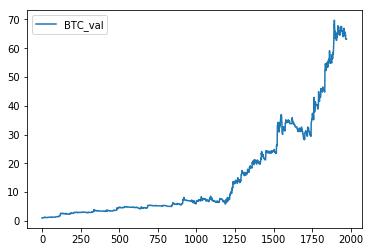

In [18]:
df.plot(y='BTC_val')

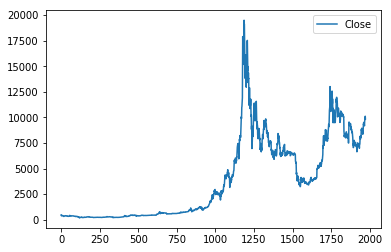

In [19]:
df.plot(y="Close")

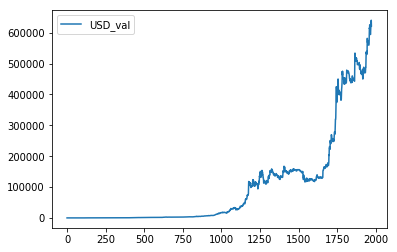

In [20]:
df.plot(y="USD_val")

** The combined graph below ** shows some correlations, in particular that bitcoin holding value tends to decrease a bit during very sharp rises in bitcoin price, although this is more than offset by the overall performance.

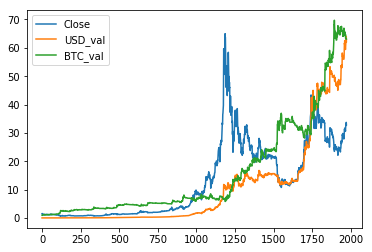

In [21]:
df2 = df
df2 = df2.drop(['Date', 'Open', 'High', 'Low', 'Volume', 'new_high', 'new_low',
       'BTC_held', 'USD_held', 'action', 'stop_val'], axis=1)
df2.Close = df2.Close / 300
df2.USD_val = df2.USD_val / 10000
df2.plot()

** Let's take a look at things went year by year. **

In [22]:
df.iloc[[105, 470, 836, 1201, 1566, 1931]]

,Date,Open,High,Low,Close,Volume,new_high,new_low,stop_val,BTC_held,USD_held,USD_val,BTC_val,action
105,2014-12-31,310.914001,320.192993,310.210999,320.192993,13942900,320.192993,0.000000,318.654176,1.410344,0.000000,451.582260,1.410344,BUY @ 318
470,2015-12-31,425.875000,432.920990,418.734985,430.566986,45996600,0.000000,418.734985,421.355383,0.000000,1566.376040,1566.376040,3.637938,SELL @ 421
836,2016-12-31,960.627014,963.742981,947.236023,963.742981,99135104,963.742981,0.000000,962.877998,4.960837,0.000000,4780.971440,4.960837,BUY @ 962
1201,2017-12-31,12897.700195,14377.400391,12755.599609,14156.400391,12136299520,14377.400391,0.000000,12720.602597,7.943919,0.000000,112457.299889,7.943919,BUY @ 12897
1566,2018-12-31,3866.839111,3868.742920,3725.867432,3742.700439,4661840806,0.000000,3725.867432,3911.135815,0.000000,122206.022151,122206.022151,32.651831,
1931,2019-12-31,7294.438965,7335.290039,7169.777832,7193.599121,21167946112,0.000000,7169.777832,7494.597348,0.000000,470509.987373,470509.987373,65.406757,


In [23]:
for [i,j,k] in ([[2015, 105, 470], [2016, 470, 836], [2017, 836, 1201], [2018, 1201, 1566], [2019, 1566, 1931]]):
    print("In " + str(i) + ", USD value of holdings changed from " + str(round((df.loc[df.index[j], "USD_val"]), 2)) + " to " + str(round((df.loc[df.index[k], "USD_val"]), 2)) + ", a change of " + str(round(((df.loc[df.index[k], "USD_val"] / df.loc[df.index[j], "USD_val"] - 1) * 100), 1)) + "%,")
    print("         BTC value of holdings changed from " + str(round((df.loc[df.index[j], "BTC_val"]), 2)) + " to " + str(round((df.loc[df.index[k], "BTC_val"]), 2)) + ", a change of " + str(round(((df.loc[df.index[k], "BTC_val"] / df.loc[df.index[j], "BTC_val"] - 1) * 100), 1)) + "%,")
    print("         and BTC price changed from " + str(round((df.loc[df.index[j], "Close"]), 2)) + " to " + str(round((df.loc[df.index[k], "Close"]), 2)) + ", a change of " + str(round(((df.loc[df.index[k], "Close"] / df.loc[df.index[j], "Close"] - 1) * 100), 1)) + "%.\n")

In 2015, USD value of holdings changed from 451.58 to 1566.38, a change of 246.9%,
         BTC value of holdings changed from 1.41 to 3.64, a change of 157.9%,
         and BTC price changed from 320.19 to 430.57, a change of 34.5%.

In 2016, USD value of holdings changed from 1566.38 to 4780.97, a change of 205.2%,
         BTC value of holdings changed from 3.64 to 4.96, a change of 36.4%,
         and BTC price changed from 430.57 to 963.74, a change of 123.8%.

In 2017, USD value of holdings changed from 4780.97 to 112457.3, a change of 2252.2%,
         BTC value of holdings changed from 4.96 to 7.94, a change of 60.1%,
         and BTC price changed from 963.74 to 14156.4, a change of 1368.9%.

In 2018, USD value of holdings changed from 112457.3 to 122206.02, a change of 8.7%,
         BTC value of holdings changed from 7.94 to 32.65, a change of 311.0%,
         and BTC price changed from 14156.4 to 3742.7, a change of -73.6%.

In 2019, USD value of holdings changed from 12220

** Even in 2018, when the price of bitcoin declined by 73.6%, ** the dollar value of the holding increased by a small percentage, and in each of the other years it more than tripled.

Of course, the fact that the strategy has worked extremely well on a 5-year sample of retrospective data under ideal conditions is no guarantee that it would continue to work well into the future. The strategy's performance probably suggests that this is still an immature and highly inefficient market. Also note that we have not taken into account several factors, including exchange fees, taxes and the likely difficulty in executing a stop order at precisely the stop price.